In [1]:
### IMPORTS

import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.odr import ODR, Model, Data, RealData
from scipy import optimize
from scipy import linalg
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from uncertainties import unumpy
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm
import pandas as pd

Welcome to JupyROOT 6.22/00


### Importing data

Regions are divided as follows:
- **CT** for centre cell, single quarter
- **TLL**, top left cell, top left quarter, representing the cell corner case 
- **TLR**, top left cell, top right quarter, representing any edge cell.

In [2]:
def unpack(cell_region):
        xs = []
        ys = []
        ts = []
        errts = []
        for drift_times in cell_region.dtimes:
            xs.append(drift_times.xs)
            ys.append(drift_times.ys)
            ts.append(drift_times.dtime)
            errts.append(drift_times.errdtime)
        return xs, ys, ts, errts

In [3]:
class Cell:
    def __init__(self, region):
        unpacked_region = unpack(region)
        self.x = unpacked_region[0]
        self.y = unpacked_region[1]
        self.t = unpacked_region[2]
        self.errt = unpacked_region[3]
        self.r = np.sqrt(np.array(unpacked_region[0])**2 + np.array(unpacked_region[1])**2)
        

In [4]:
CTL850 = Cell(ROOT.TFile.Open("summaryCTL850.root"))
CTL880 = Cell(ROOT.TFile.Open("summaryCTL880.root"))
CTL910 = Cell(ROOT.TFile.Open("summaryCTL910.root"))
TLL850 = Cell(ROOT.TFile.Open("summaryTLL850.root"))
TLL880 = Cell(ROOT.TFile.Open("summaryTLL880.root"))
TLL910 = Cell(ROOT.TFile.Open("summaryTLL910.root"))
TLR850 = Cell(ROOT.TFile.Open("summaryTLR850.root"))
TLR880 = Cell(ROOT.TFile.Open("summaryTLR880.root"))
TLR910 = Cell(ROOT.TFile.Open("summaryTLR910.root"))

In [5]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]

#### Scan map of coordinates

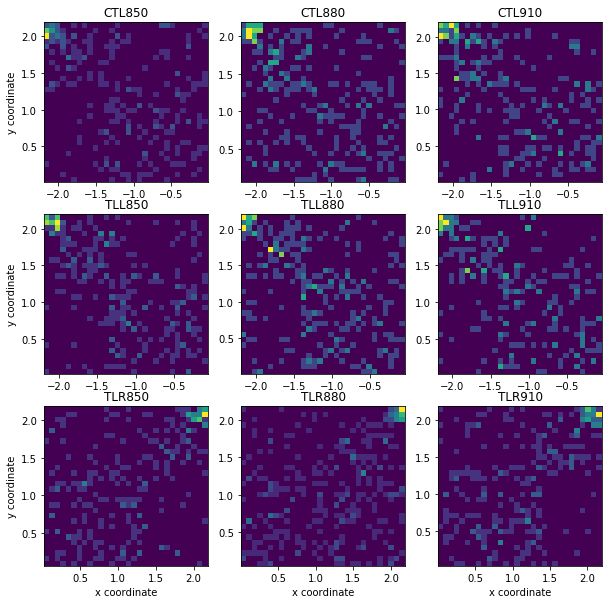

In [6]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(10,10
                                      ))
cell_names = ["CTL850", "CTL880", "CTL910", "TLL850", "TLL880", "TLL910", "TLR850", "TLR880", "TLR910"]
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]           
        axs[i,j].hist2d(regions[count].x,regions[count].y,bins=30)
        axs[i,j].set_title(label)
        axs[i,0].set_ylabel('y coordinate')
        axs[2,j].set_xlabel('x coordinate')

        count += 1
#figs.colorbar()


Text(0.5, 1.0, 'Centre cell (CTL)')

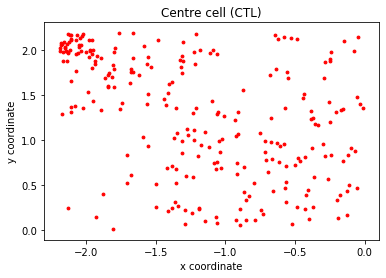

In [7]:
plt.scatter(CTL850.x,CTL850.y,color='red',s=8)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Centre cell (CTL)')

Text(0.5, 1.0, 'Edge cell (TLR)')

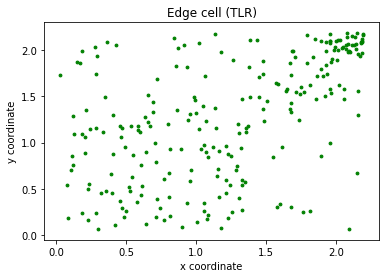

In [8]:
plt.scatter(TLR850.x,TLR850.y,color='green',s=8)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Edge cell (TLR)')

Text(0.5, 1.0, 'Corner cell (TLL)')

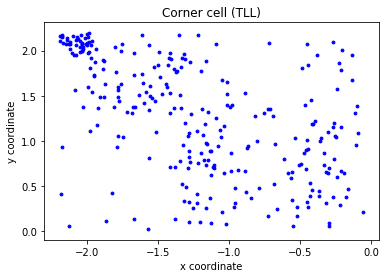

In [9]:
plt.scatter(TLL850.x,TLL850.y,color='blue',s=8)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Corner cell (TLL)')

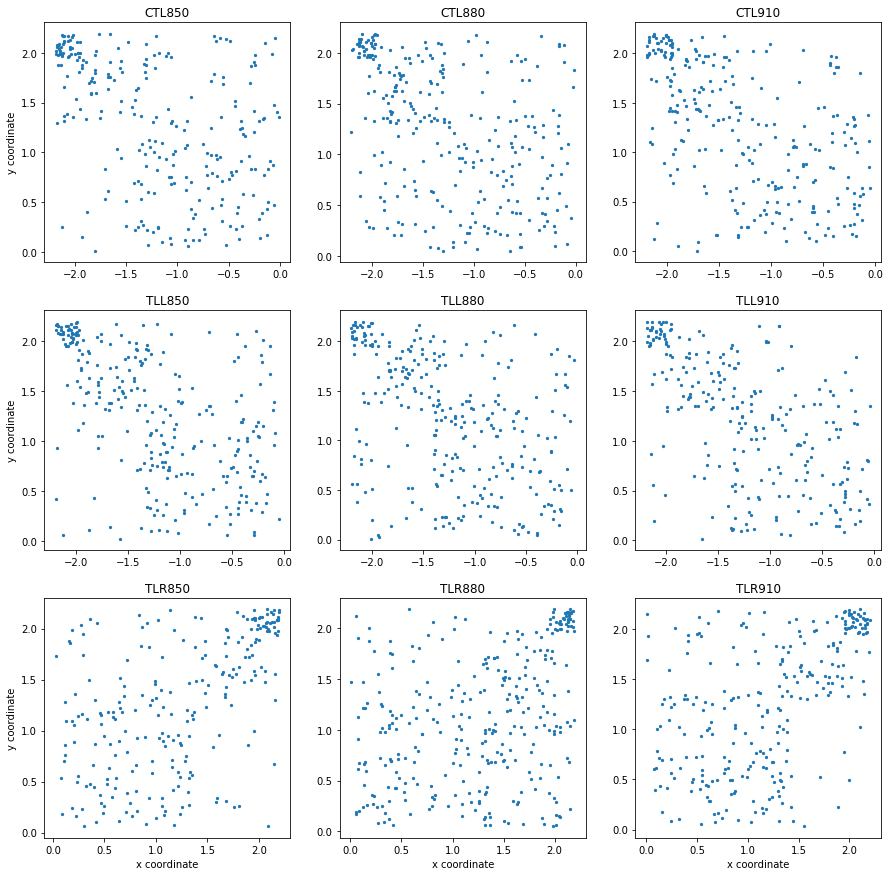

In [10]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(15,15))
cell_names = ["CTL850", "CTL880", "CTL910", "TLL850", "TLL880", "TLL910", "TLR850", "TLR880", "TLR910"]
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]           
        axs[i,j].scatter(regions[count].x,regions[count].y,s=5)
        axs[i,j].set_title(label)
        axs[i,0].set_ylabel('y coordinate')
        axs[2,j].set_xlabel('x coordinate')

        count += 1

In [11]:
plt.rcParams['axes.formatter.limits'] = [-5,6]

#### Fitting distance to time

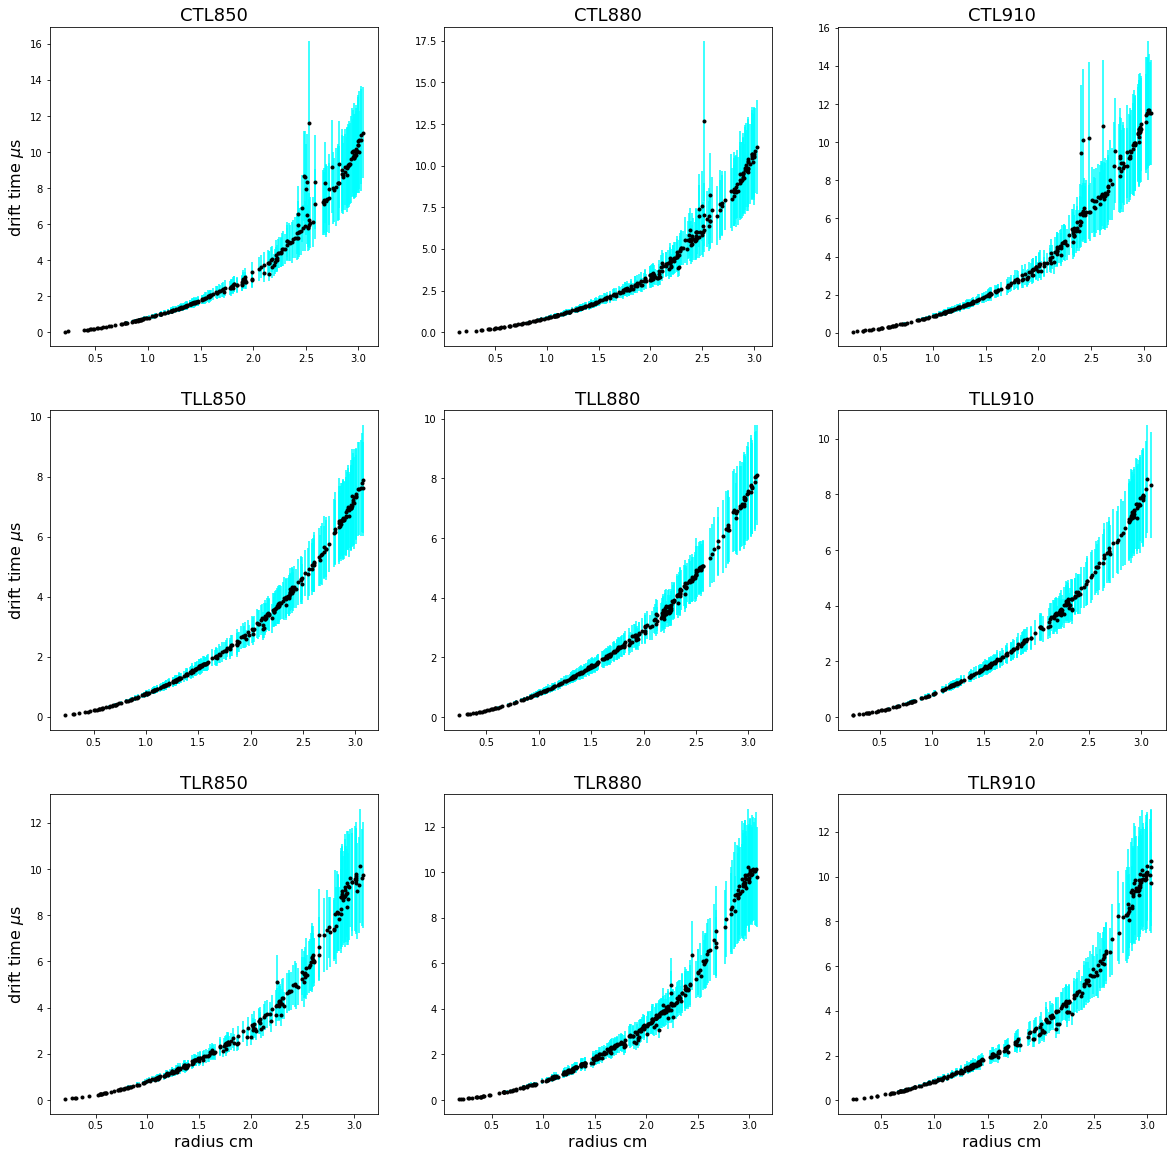

In [12]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(20,20))
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]
        axs[i,j].errorbar(regions[count].r,np.array(regions[count].t)/1e-6,yerr=np.array(regions[count].errt)/1e-6,fmt='.',ecolor = 'cyan',color='black')
        axs[i,j].set_title(label,fontsize=18)
        axs[i,0].set_ylabel(r'drift time $\mu$s',fontsize=16)
        axs[2,j].set_xlabel('radius cm',fontsize=16)

        count += 1

Drift time equation as a function of radial distance:
$$t(r) = \frac{a \times r}{r^b}$$

**Yorick's initial parameters:**

$0<r<2.2$, a = $1\times 10^{-6}$, b = $-0.9$

$2.2<r<3.5$, a = $1\times 10^{-6}$, b = $-2$


In [13]:
def trialfunc(r,a,b):
    """ A function that calculates time from distance"""
    denom = r**b
    return a*r / denom

In [14]:
r_CTL850 = np.array(CTL850.r)
drift_CTL850 = np.array(CTL850.t)
err_CTL850 = np.array(CTL850.errt)

In [15]:
r_022 = r_CTL850[r_CTL850<2.2]
drift_022 = drift_CTL850[r_CTL850<2.2]
err_022 = err_CTL850[r_CTL850<2.2]

In [16]:
r_2235 = r_CTL850[r_CTL850>=2.2]
drift_2235 = drift_CTL850[r_CTL850>=2.2]
err_2235 = err_CTL850[r_CTL850>=2.2]

In [17]:
a_guess = 1e-6
b_guess=-0.9 #for 0 to x=2.2
b_guess2=-2.0 #for x>2.2

In [18]:
popt,pcov = curve_fit(trialfunc,r_022,drift_022,p0=[a_guess,b_guess],sigma=err_022)

In [19]:
popt,pcov

(array([ 8.28226276e-07, -9.07466222e-01]),
 array([[3.42374542e-18, 2.66682480e-12],
        [2.66682480e-12, 2.15403264e-05]]))

In [20]:
popt2,pcov2 = curve_fit(trialfunc,r_2235,drift_2235,p0=[a_guess,b_guess2],sigma=err_2235)
perr = np.sqrt(np.diag(pcov))
perr2 = np.sqrt(np.diag(pcov2))


In [21]:
r1 = np.linspace(0.01,2.2)
r2 = np.linspace(2.2,3.1)

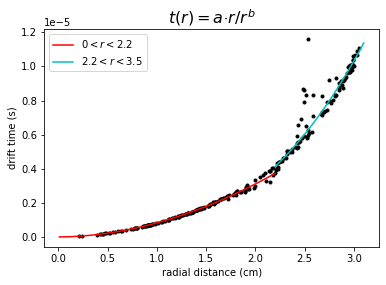

In [22]:
plt.plot(r_CTL850,drift_CTL850,'k.')
plt.plot(r1,trialfunc(r1,popt[0],popt[1]),'r',label=r'$0<r<2.2$')
plt.plot(r2,trialfunc(r2,popt2[0],popt2[1]),'c',label=r'$2.2<r<3.5$')
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.title(r'$t(r) = a \dot r/r^b$',fontsize=16)
plt.show()

In [23]:
def perform_fit(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt,pcov = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    perr = np.sqrt(np.diag(pcov))
    
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess],sigma=err_up)
    perr2 = np.sqrt(np.diag(pcov2))

    return popt,perr,popt2,perr2

**Inverse function:** Radial distance as a function of drift time:
$$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$$

**Error propagation:** 
$$\begin{equation}
\sigma_r^2 = \sigma_a^2(\frac{\partial r}{\partial a})^2 + \sigma_b^2(\frac{\partial r}{\partial b})^2 + \sigma_t^2(\frac{\partial r}{\partial t})^2
\end{equation}$$


In [24]:
def invertfunc(t,a,b):
    
    """ A function that calculates distance from time"""
    power = (1/(1-b))
    
    return (t/a)**power

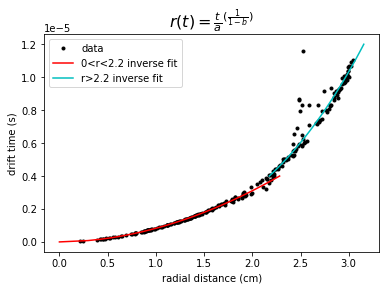

In [25]:
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(tfine,popt[0],popt[1]),tfine,'r-',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 inverse fit')
plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

In [26]:
import csv

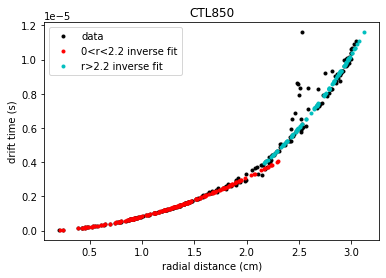

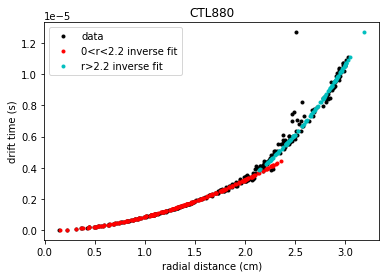

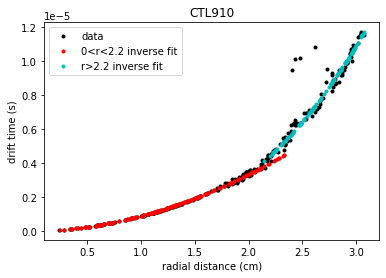

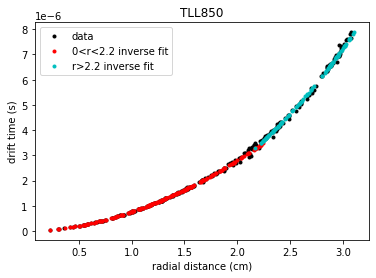

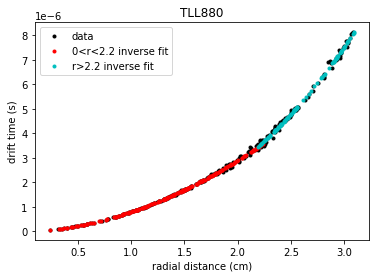

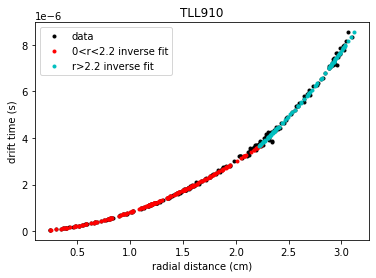

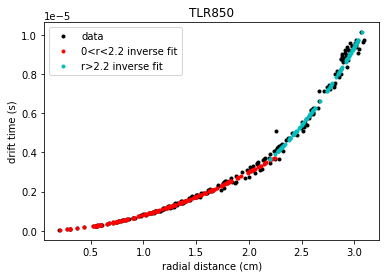

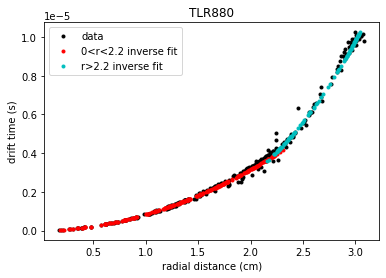

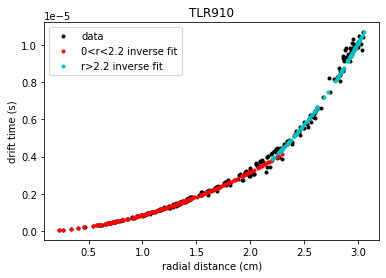

In [27]:
f2 = open('drift_parameters.csv','w')
f2.write('{} {} {} {} {} {} {} {}\n'.format('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2'))
#f2.write('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2')
count = 0
for region in regions:
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    plt.plot(region.r,region.t,'k.',label='data')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)<2.2],popt[0],popt[1]),np.array(region.t)[np.array(region.r)<2.2],'r.',label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
    plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
    plt.legend()
    plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()
    count+=1
    f2.write('{} {} {} {} {} {} {} {}\n'.format(popt[0],perr[0],popt[1],perr[1],popt2[0],perr2[0],popt2[1],perr2[1]))

In [28]:
## since the asymmetry around 2.2 is largest in centre>edge>corner, expect fit to be worse for CTL>TLR>TLL and this is true

In [29]:
## the problem here is that also depends on where you chose the drift time corresponding to 2.2 to be.

In [30]:
def perform_fit_err(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt1,pcov1 = curve_fit(trialfunc,r_low,time_low+err_low,p0=[a_guess,b_guess])#,sigma=err_low)
    popt2,pcov2 = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    popt3,pcov3 = curve_fit(trialfunc,r_low,time_low-err_low,p0=[a_guess,b_guess])#,sigma=err_low)

    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))


    return popt1,perr1,popt2,perr2,popt3,perr3

In [31]:
def perform_fit_err_high(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt1,pcov1 = curve_fit(trialfunc,r_up,time_up+err_up,p0=[a_guess,b_guess])#,sigma=err_low)
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess],sigma=err_up)
    popt3,pcov3 = curve_fit(trialfunc,r_up,time_up-err_up,p0=[a_guess,b_guess])#,sigma=err_low)

    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))


    return popt1,perr1,popt2,perr2,popt3,perr3

In [32]:
popt1,perr1,popt2,perr2,popt3,perr3 = perform_fit_err(CTL850,2.2)

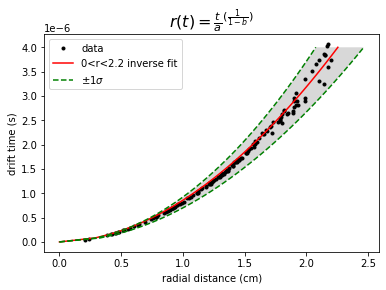

In [33]:
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
plt.plot(r_CTL850[r_CTL850<2.2],drift_CTL850[r_CTL850<2.2],'k.',label='data')
plt.plot(invertfunc(tfine,popt[0],popt[1]),tfine,'r-',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,'g--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,'g--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine,popt1[0],popt1[1])
y2 = invertfunc(tfine,popt3[0],popt3[1])
#x = 
plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.3)

plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

In [34]:
popt4,perr4,popt5,perr5,popt6,perr6 = perform_fit_err_high(CTL850,2.2)

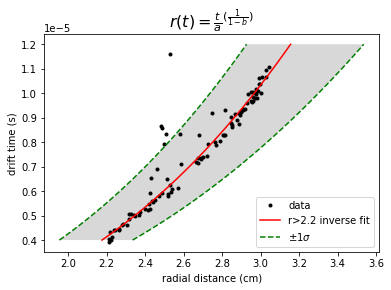

In [35]:
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
plt.plot(r_CTL850[r_CTL850>=2.2],drift_CTL850[r_CTL850>=2.2],'k.',label='data')
plt.plot(invertfunc(tfine2,popt5[0],popt5[1]),tfine2,'r-',label='r>2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'g--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine2,popt6[0],popt6[1]),tfine2,'g--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine2,popt4[0],popt4[1])
y2 = invertfunc(tfine2,popt6[0],popt6[1])
#x = 
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.3)
#plt.errorbar(r_2235,drift_2235,yerr=err_2235,fmt='.',ecolor = 'pink',color='red',label='data')

plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

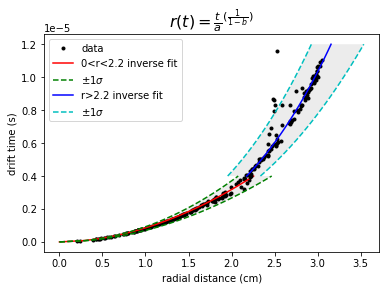

In [36]:
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
plt.plot(r_CTL850[r_CTL850<2.2],drift_CTL850[r_CTL850<2.2],'k.',label='data')
plt.plot(invertfunc(tfine,popt[0],popt[1]),tfine,'r-',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,'g--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,'g--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine,popt1[0],popt1[1])
y2 = invertfunc(tfine,popt3[0],popt3[1])
#x = 
plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.15)

plt.plot(r_CTL850[r_CTL850>=2.2],drift_CTL850[r_CTL850>=2.2],'k.')#,label='data')
plt.plot(invertfunc(tfine2,popt5[0],popt5[1]),tfine2,'b-',label='r>2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'c--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine2,popt6[0],popt6[1]),tfine2,'c--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine2,popt4[0],popt4[1])
y2 = invertfunc(tfine2,popt6[0],popt6[1])
#x = 
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.15)

plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

### fitting for $r < 2.2$ and $2.2 \leq r$

In [37]:
def chi2_022(params):
    a,b = params
    i = invertfunc(drift_022,a,b)
    res = np.sum((r_022-i)**2/r_022)#np.sum(((new_x-k)**2)/new_x)
    return res

In [38]:
def chi2_2235(params):
    a,b = params
    i = invertfunc(drift_2235,a,b)
    res = np.sum((r_2235-i)**2/r_2235)#np.sum(((new_x-k)**2)/new_x)
    return res

In [39]:
chi2_022((popt[0],popt[1]))

0.10082009001062592

In [40]:
chi2_2235((popt2[0],popt2[1]))

11.207109205010308

In [41]:
sol = optimize.least_squares(chi2_022, x0=[popt[0],popt[1]])
sol.x

/tmp/ipykernel_5418/401701534.py:6: RuntimeWarning: invalid value encountered in power
  return (t/a)**power


array([ 8.38897183e-07, -8.94958512e-01])

In [42]:
sol2 = optimize.least_squares(chi2_2235, x0=[popt2[0],popt2[1]])
sol2.x

array([ 1.16628379e-06, -9.07466222e-01])

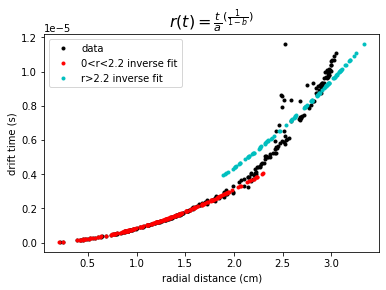

In [43]:
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(drift_022,sol.x[0],sol.x[1]),drift_022,'r.',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(drift_2235,sol2.x[0],sol2.x[1]),drift_2235,'c.',label='r>2.2 inverse fit')
plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

In [44]:
def perform_fit(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt,pcov = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    perr = np.sqrt(np.diag(pcov))
    
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess],sigma=err_up)
    perr2 = np.sqrt(np.diag(pcov2))

    return popt,perr,popt2,perr2

In [45]:
def error_propagation(ts,errts,a,erra,b,errb):
    t_tuple = unumpy.uarray(ts, errts)
    a_tuple = unumpy.uarray(a, erra)
    b_tuple = unumpy.uarray(b, errb)
    r = (t_tuple/a_tuple)**(1/(1-b_tuple))
    err = unumpy.std_devs(r)
    val = unumpy.nominal_values(r)
    return err, val

In [46]:
def inversefit_plot(region,label):
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
    err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
    plt.errorbar(region.r,np.array(region.t),yerr=np.array(region.errt),fmt='.',ecolor = 'pink',color='red',label='data')
    plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
    plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'green',alpha=0.2,color='black',label='prediction r>2.2')
    plt.legend(loc='upper left')
    plt.title('Inverse fit with error bars'+' '+str(label))
    plt.ylabel(r'drift time (s)')
    plt.xlabel('radial distance (cm)')
    plt.show()

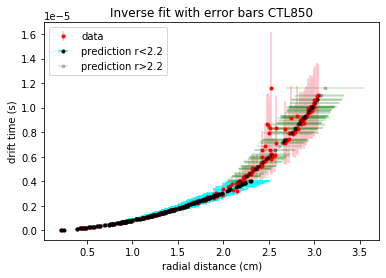

In [47]:
inversefit_plot(CTL850,'CTL850')

Pull plot:
$$\frac{\hat{\chi} - \chi}{\sigma}$$

In [48]:
region = TLR850

In [49]:
popt,perr,popt2,perr2 = perform_fit(region,2.2)
err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])

In [50]:
pull1 = (val1-TLR850.r[TLR850.r < 2.2])/err1;

In [51]:
pull2 = (val2-TLR850.r[TLR850.r >= 2.2])/err2;

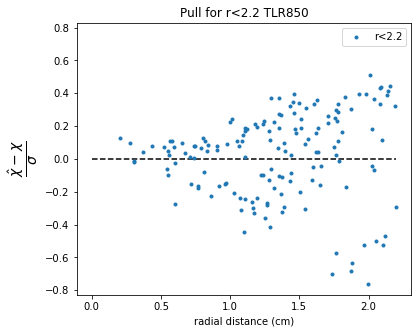

In [52]:
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(TLR850.r[TLR850.r < 2.2],pull1,'.',label='r<2.2')
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
ax.set_xlabel('radial distance (cm)')
plt.title('Pull for r<2.2 TLR850')
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
plt.legend()
         

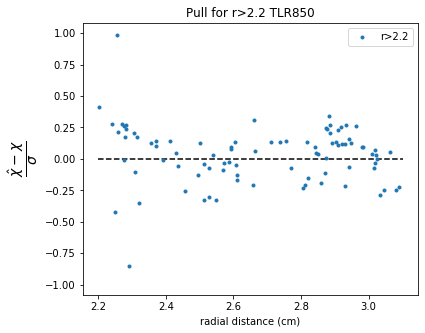

In [53]:
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(TLR850.r[TLR850.r >= 2.2],pull2,'.',label='r>2.2')
ax.hlines(y=0,xmin=2.2,xmax=3.1,linestyles='dashed')
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
plt.title('Pull for r>2.2 TLR850')
ax.set_xlabel('radial distance (cm)')
ax.set_xlabel('radial distance (cm)')
plt.legend()
plt.show()
#plt.axes([2.2,3.2,-1,1])

**distance on the x axis and then measured-fitted on the y axis (basically don't divide through by the uncertainty) but then draw on the line that shows what the uncertainty +/- 1 sigma would be**

In [54]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions)):
    popt,perr,popt2,perr2 = perform_fit(regions[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])


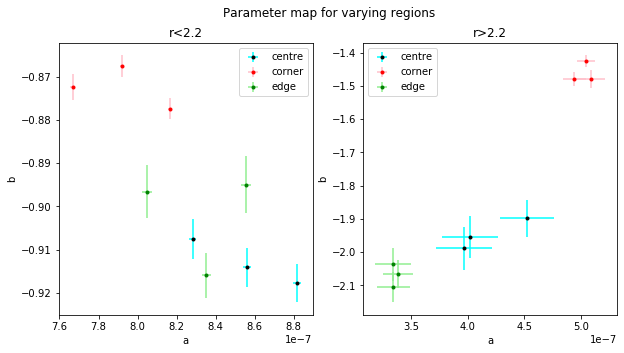

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying regions')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

In [56]:
regions2 = [CTL850, TLL850, TLR850, CTL880, TLL880, TLR880, CTL910, TLL910, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])

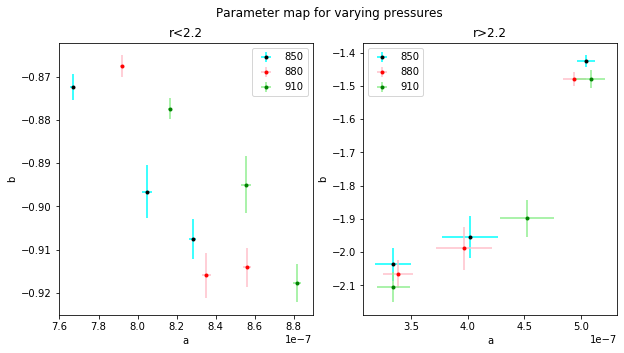

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

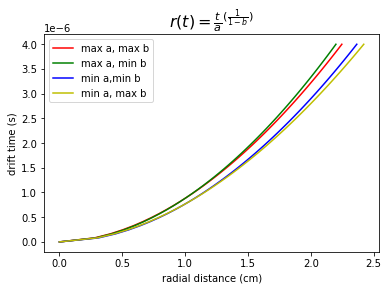

In [58]:
###finding physical meaning of a and b

tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
#plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(tfine,max(a),max(b)),tfine,'r-',label='max a, max b')
plt.plot(invertfunc(tfine,max(a),min(b)),tfine,'g-',label='max a, min b')
plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a,min b')
plt.plot(invertfunc(tfine,min(a),max(b)),tfine,'y-',label='min a, max b')

#plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 inverse fit')
plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

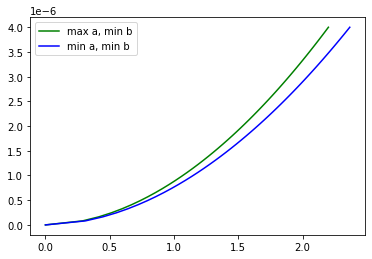

In [59]:
plt.plot(invertfunc(tfine,max(a),min(b)),tfine,'g-',label='max a, min b')
plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a, min b')
plt.legend()

In [60]:
h = np.array(a)/1e-7

In [61]:
b7 = np.array(b).reshape(3,3)

In [62]:
Blues = plt.get_cmap('Blues')

In [63]:
h3 = h.reshape(3,3)

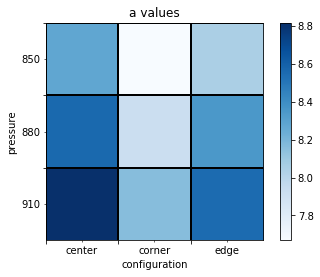

In [64]:
fig, ax = plt.subplots()
u = ax.imshow(h3, cmap=Blues)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('a values')
ax.set_xticklabels(['center','corner','edge'])
ax.set_yticklabels(['850','880','910'])
ax.set_xlabel('configuration')
ax.set_ylabel('pressure')

# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)

fig.colorbar(u)
#ax.set_yticks([])
#ax.set_xticks([])

plt.show()

In [65]:
Summer = plt.get_cmap('Reds')

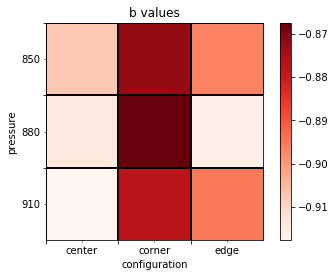

In [66]:
fig, ax = plt.subplots()
u = ax.imshow(b7, cmap=Summer)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('b values')

ax.set_xlabel('configuration')
ax.set_ylabel('pressure')
# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)


fig.colorbar(u)
plt.show()

#### ANGULAR DEPENDENCE

Alternative drift models are
under investigation for SuperNEMO, some of which include the angle of incidence of
the track as a parameter.

In [67]:
import math
import scipy.interpolate

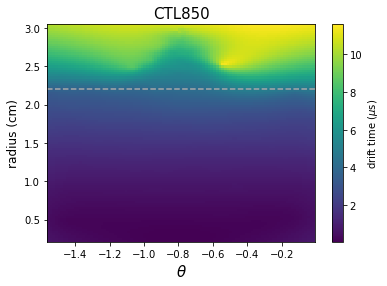

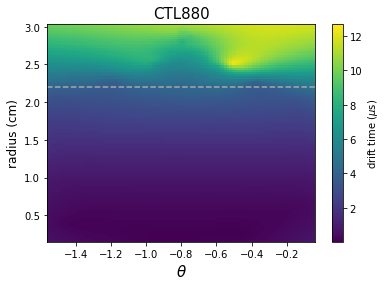

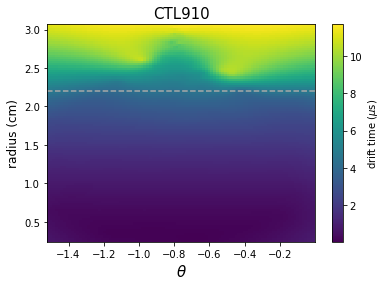

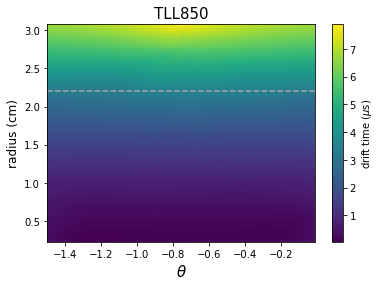

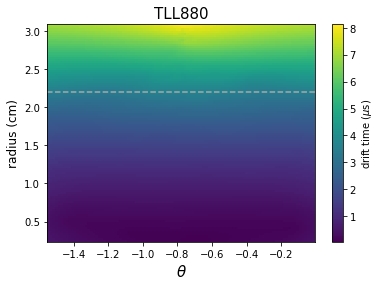

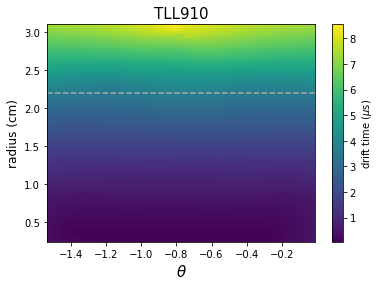

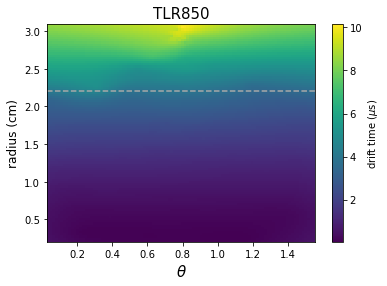

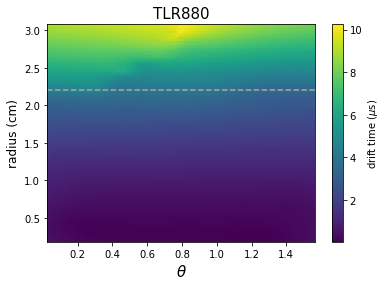

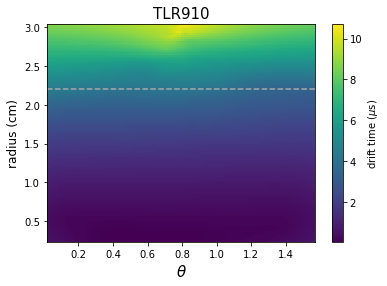

In [68]:
count = 0
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)

    plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
               extent=[x.min(), x.max(), y.min(), y.max()],aspect='auto')
    plt.title(cell_names[count],fontsize=15)
    cbar = plt.colorbar()
    cbar.set_label(r'drift time ($\mu$s)')
    plt.xlabel(r'$\theta$',fontsize=15)
    plt.ylabel(r'radius (cm)',fontsize=12)
    plt.axhline(y = 2.2, color = 'darkgray', linestyle = '--')

    plt.show()
    
    count+=1


In [69]:
new_regions = [CTL850, TLL850, TLR850]

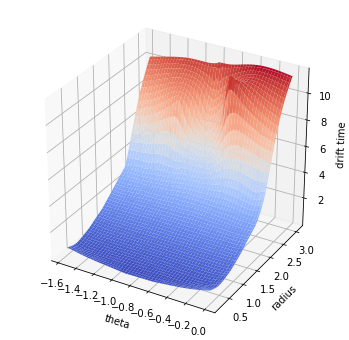

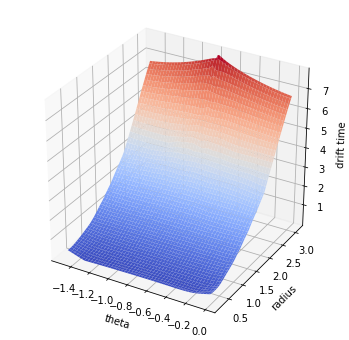

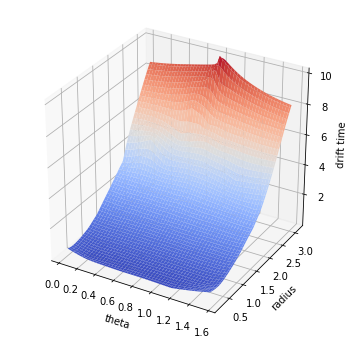

In [70]:
for region in new_regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(xi, yi, zi, cmap='coolwarm')

    ax.set_xlabel('theta')
    ax.set_ylabel('radius')
    ax.set_zlabel('drift time')

    plt.show()

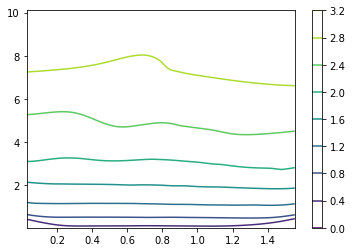

In [71]:
levels=np.arange(0,3.4,0.4)
cs = plt.contour(xi,zi,yi,levels=levels)
plt.colorbar(cs)
#for a constant radius (i.e. y is the LEVEL as this is a line of constant r, what is the drift time according to the angle)

(0, 3)

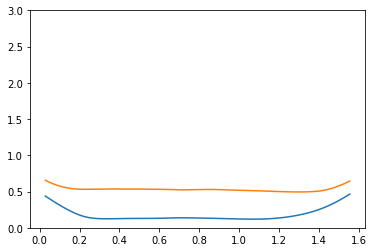

In [72]:
##how to extract contour lines to be modelled
plt.plot(cs.allsegs[1][0][:,0],cs.allsegs[1][0][:,1])
plt.plot(cs.allsegs[2][0][:,0],cs.allsegs[2][0][:,1])
plt.plot(cs.allsegs[6][0][:,0],cs.allsegs[6][0][:,1])

plt.ylim([0,3])

## we can model these asymmetries

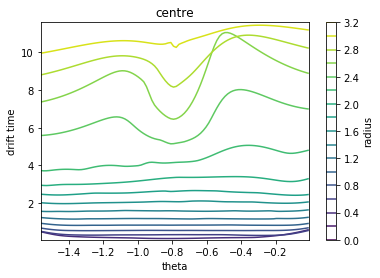

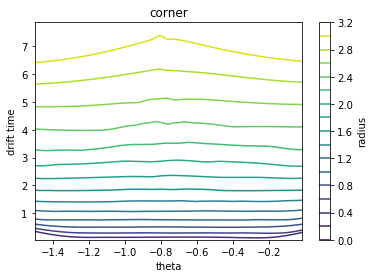

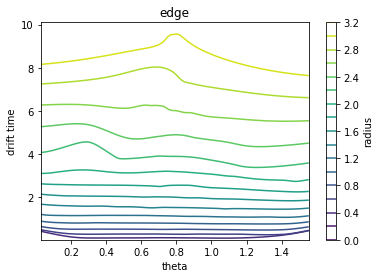

In [73]:
count=0
for region in new_regions:
    name=['centre','corner','edge']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    levels=np.arange(0,3.4,0.2)
    cs = plt.contour(xi,zi,yi,levels=levels)
    plt.colorbar(cs,label='radius')
    #for a constant ra

    plt.xlabel('theta')
    plt.ylabel('drift time')
    plt.title(name[count])
    plt.show()
    count+=1

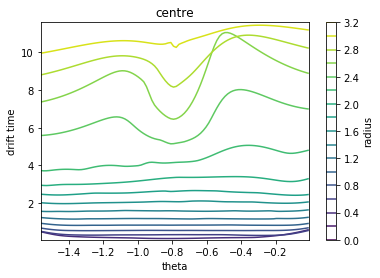

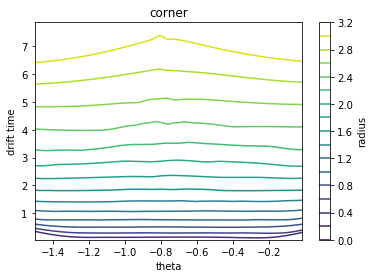

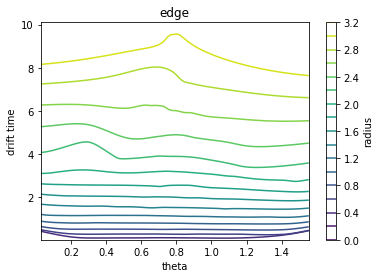

In [74]:
count=0
for region in new_regions:
    name=['centre','corner','edge']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    levels=np.arange(0,3.4,0.2)
    cs = plt.contour(xi,zi,yi,levels=levels)
    plt.colorbar(cs,label='radius')
    #for a constant ra

    plt.xlabel('theta')
    plt.ylabel('drift time')
    plt.title(name[count])
    plt.show()
    count+=1

uniform means now theta dependence - clear theta dependence in edge and centre cells

(-1.5707963267948966, 0)

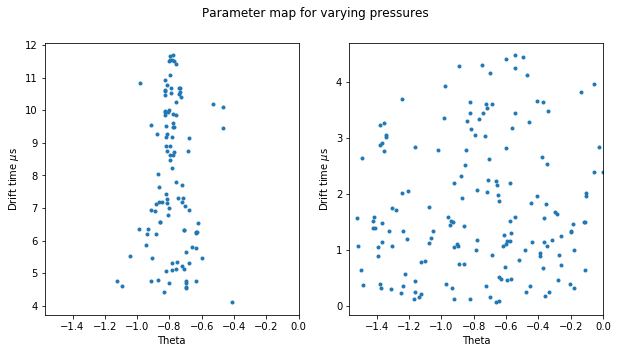

In [75]:
region = CTL910
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
data = list(zip(theta,z,y))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
df_r1 = dframe[dframe['radius'].between(2.2, 3.1, inclusive=False)]
df_r2 = dframe[dframe['radius'].between(0, 2.2, inclusive=False)]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')

ax1.plot(df_r1['theta'],df_r1['drift time'],'.')
ax2.plot(df_r2['theta'],df_r2['drift time'],'.')

ax1.set_xlabel('Theta')
ax2.set_xlabel('Theta')

ax1.set_ylabel(r'Drift time $\mu$s')
ax2.set_ylabel(r'Drift time $\mu$s')

ax1.set_xlim([-np.pi/2,0])
ax2.set_xlim([-np.pi/2,0])

the shape of this is due to how it is sampled (imagine filling in a square w circ radius 2.2 , not many sampling points in the v high and v low theta values. since the gaussian is filled, there still shows no real trend between theta and drift time

-----------------------------------------------------------------------------------------------------------------------------

#### Next steps:

NEMO3 Drift Model:

$$r = \frac{A \times t_{\text{Anode}}}{t_{\text{Anode}}^B + C}$$

Aim - Given $t$ from cathode data, obtain radius and uncertainty, $r(t) + \sigma_r$

$\sigma_r = \sigma_{\text{fit}} + \sigma_{\text{time}} + \sigma_{\text{ionization}} + \sigma_{\text{systematic}}$

where $\sigma_{\text{systematic}} \geq 0.5$mm (partially includes ionization error). This error comes from the minimum resolution from the nemo3 detector (see ashwins thesis page 79)

- Up to three timing signals were recorded for each Geiger cell traversed by a
muon, the arrival times of signals on the anode wire and the two cathode end-caps
relative to the trigger. The former is referred to as the “drift time” and relates to the
radial distance of closest approach of the muon to the tracking wire.

Find formula for ionization/diffusion uncertainty given distance of closest approach

 - how does a change in parameter affect uncertaint of the model

In standard operation, a potential difference of around 1800 V is applied between
the grounded field shaping wires and the anode wire. The optimal operating voltage
is specific to each cell, depending on the position of the cell in the array (i.e.,
the number of neighbouring cells) and on the intrinsic properties of the cell. The
main properties which characterise a tracker cell are the Geiger plateau width, the
avalanche propagation efficiency and the avalanche propagation time.


In [76]:
### the reason the fit is bad at 2.2 is because of the new asmmetry of the cell 
# - if you can model for assymetry can you model for 2.2